# Задача:

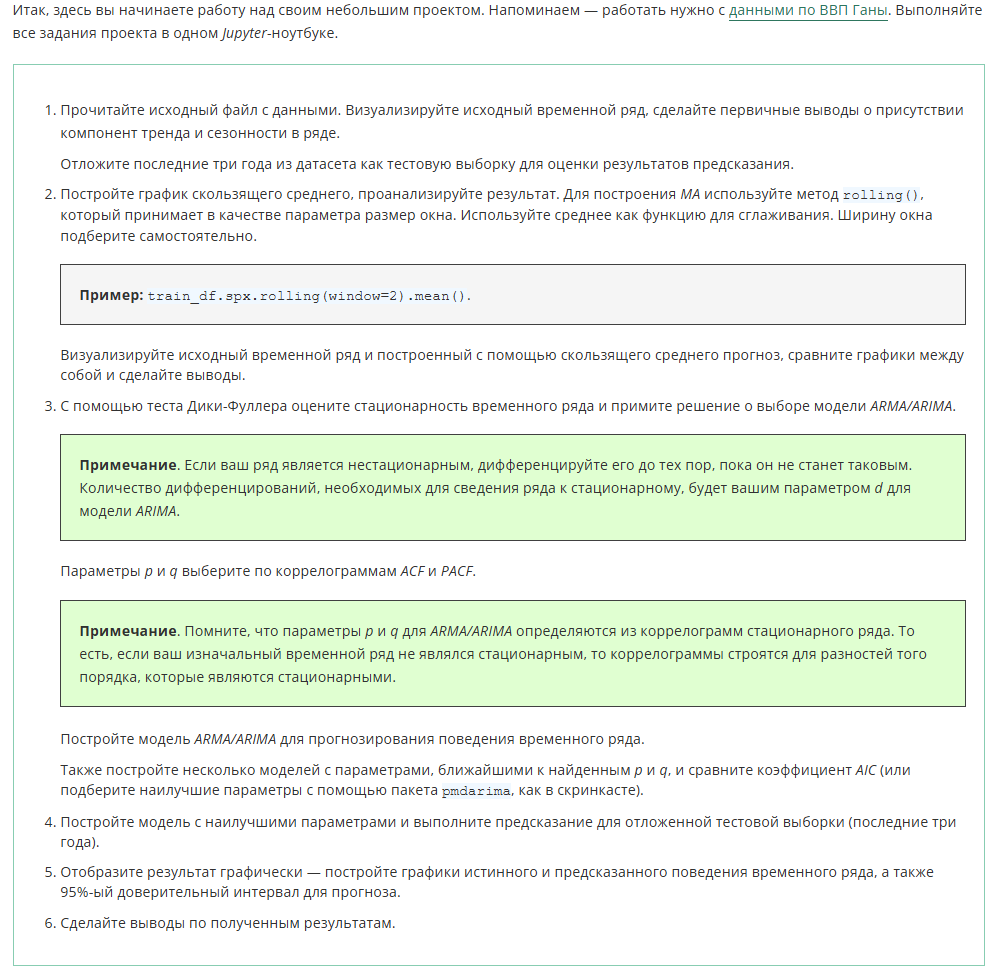

In [81]:
import pandas as pd
from warnings import filterwarnings
filterwarnings("ignore")
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

### 1. Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.

In [82]:
data = pd.read_csv("data/ghana_gdp.csv", parse_dates=["year"], index_col=["year"])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


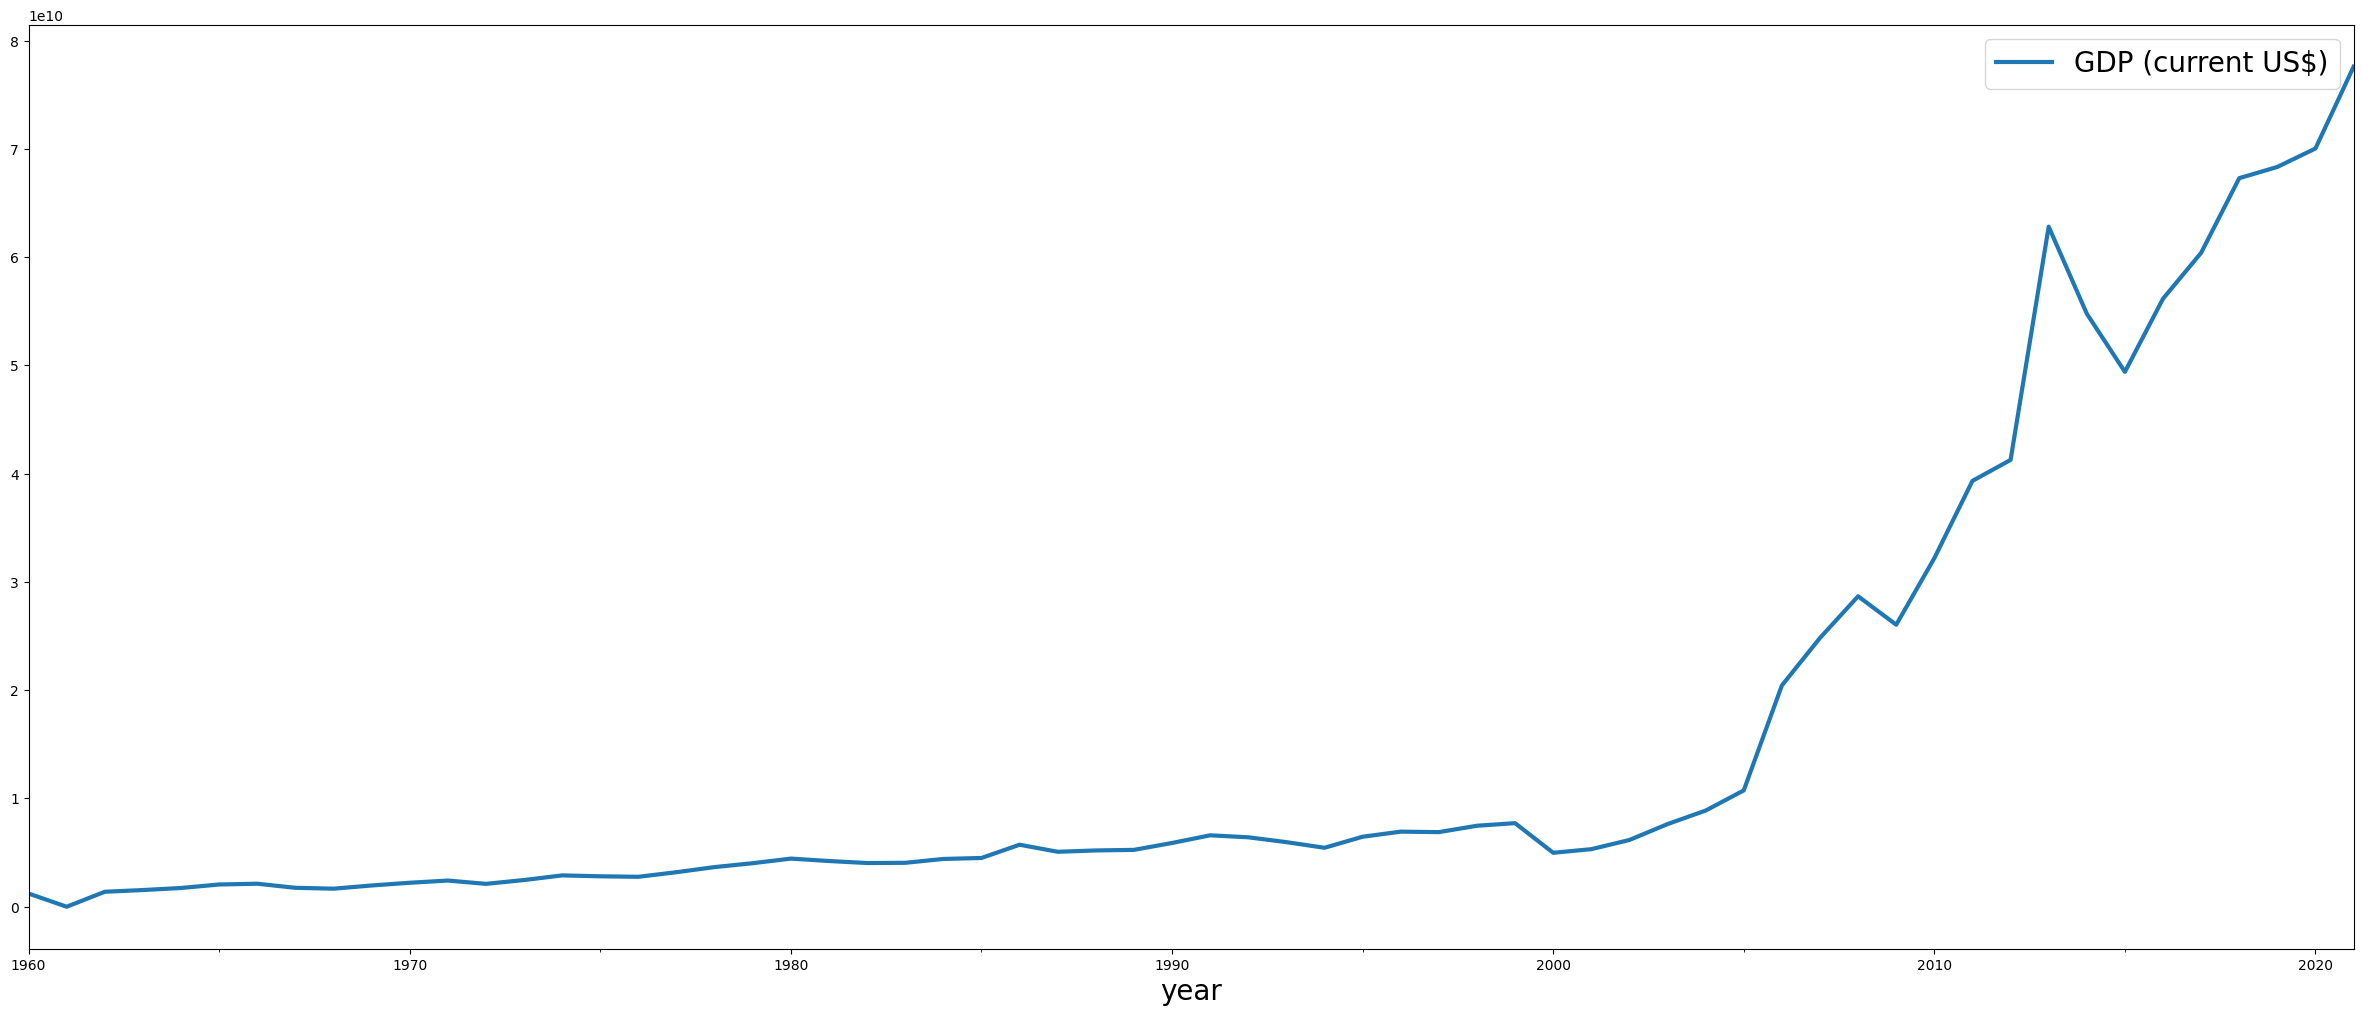

In [83]:
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

In [84]:
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

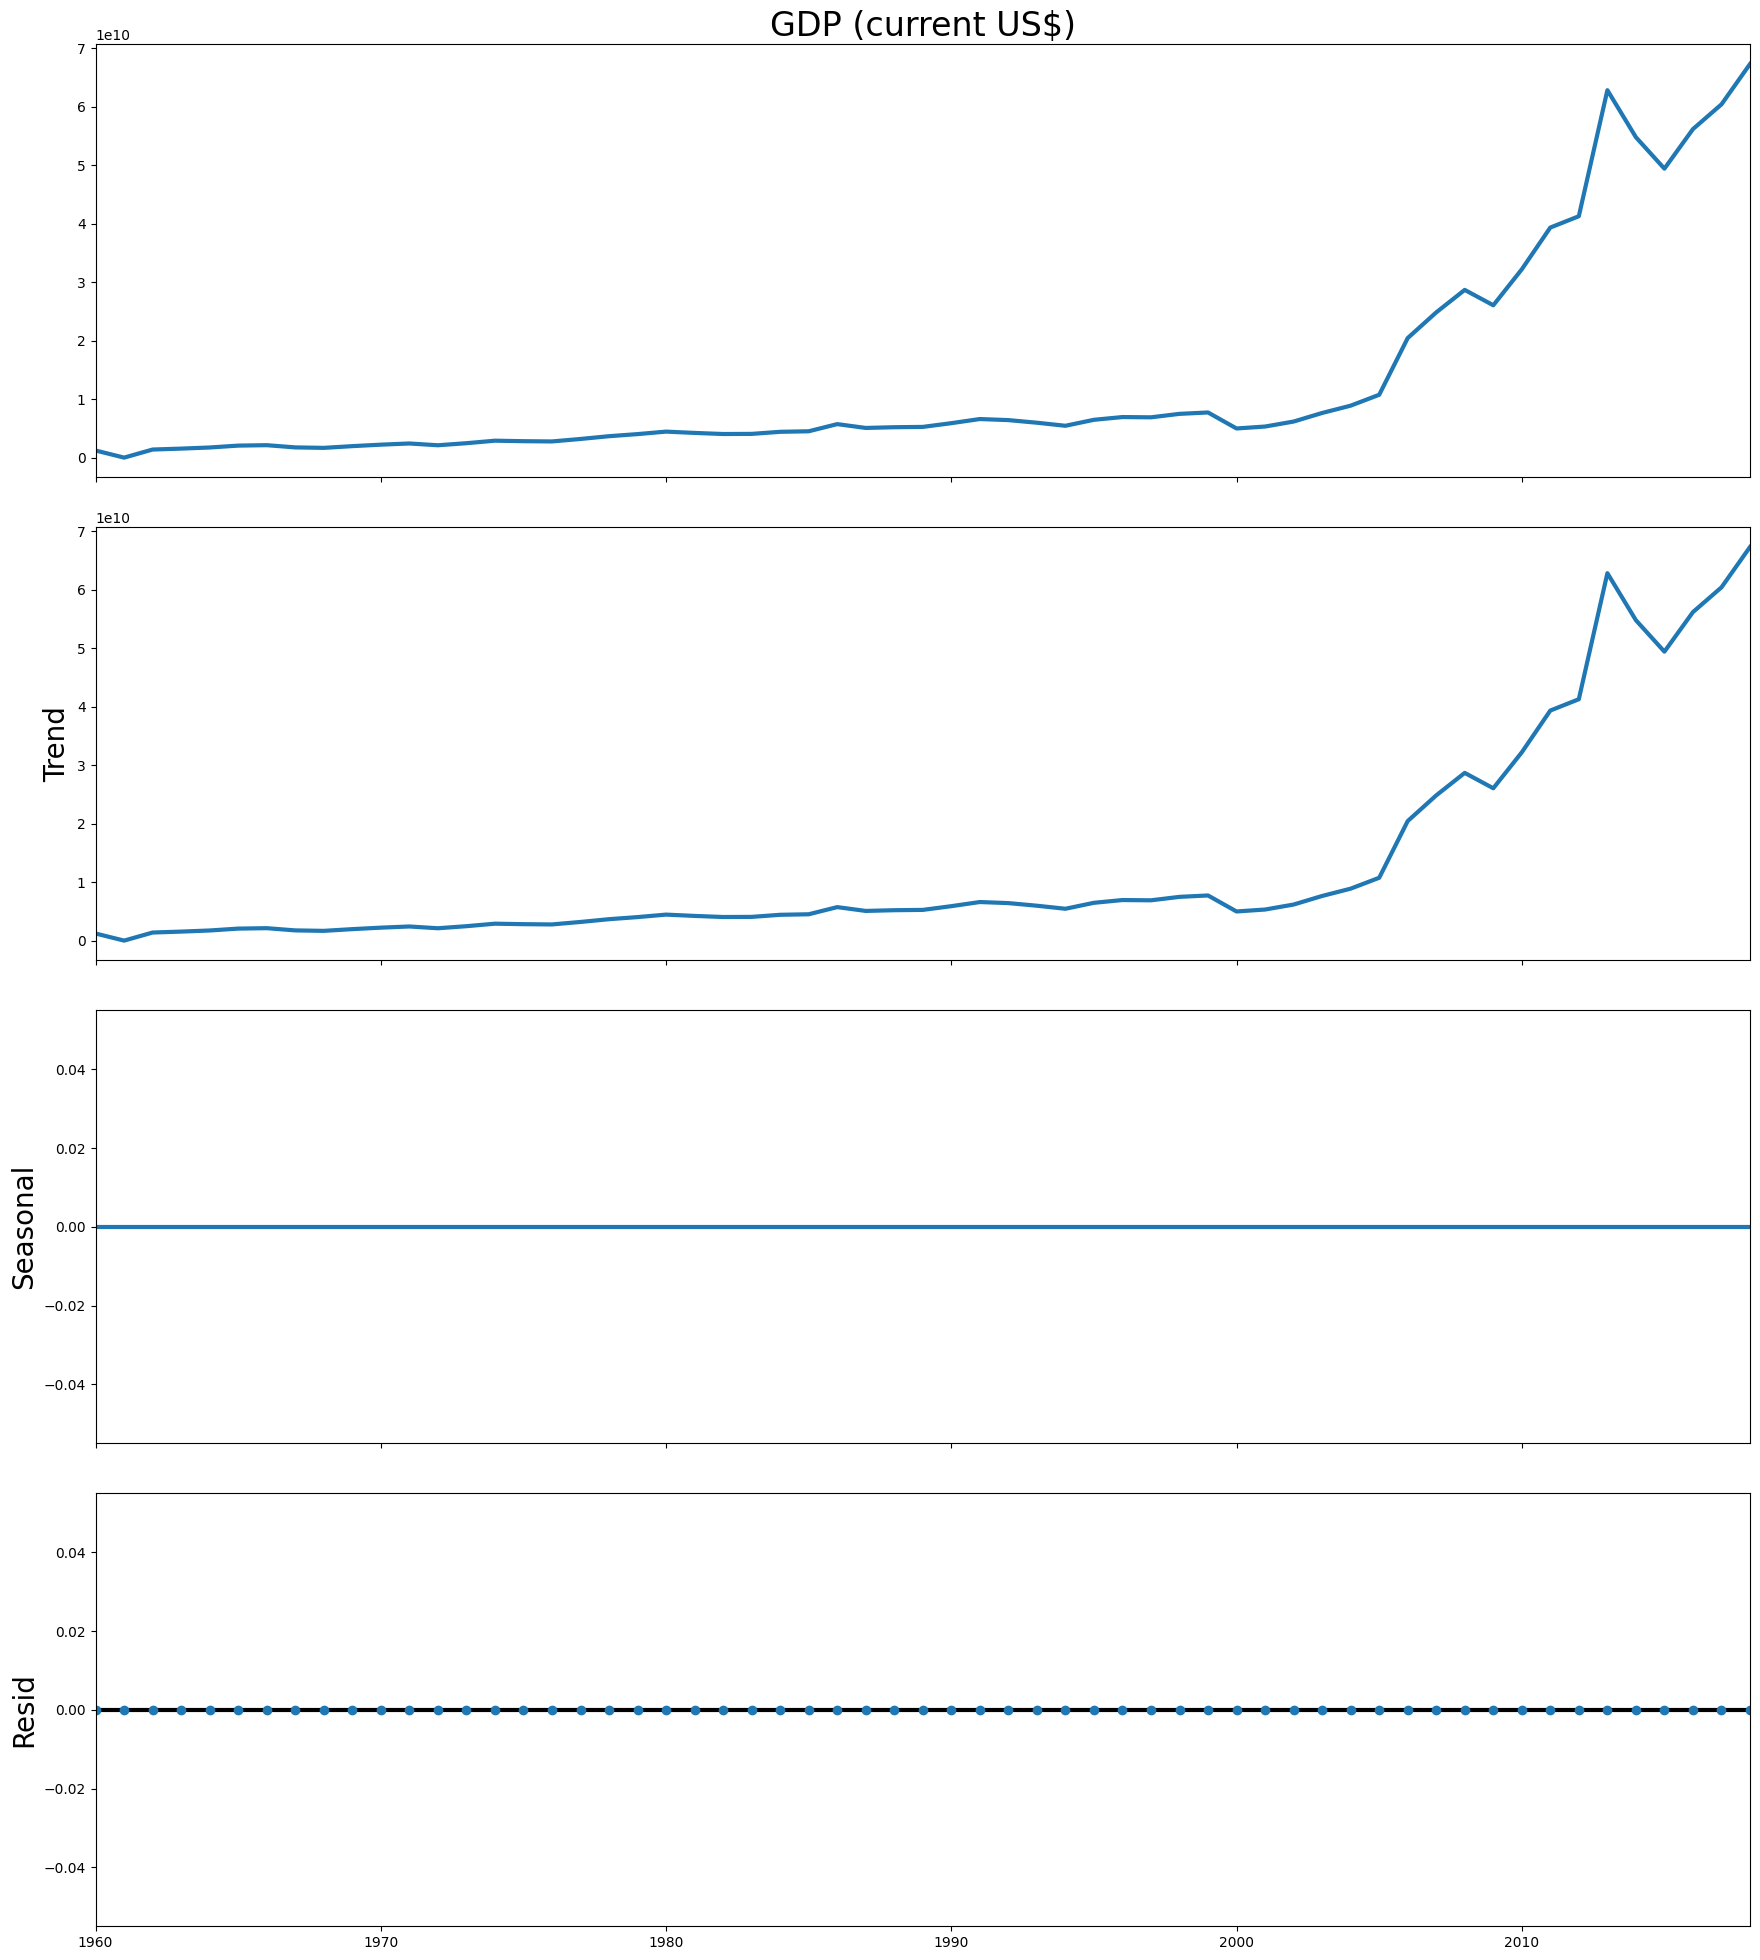

In [85]:
plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df["GDP (current US$)"])
result.plot()
plt.show()

> Вывод:
> - Четко прсолеживает тренд.
> - Сезонность отсутствует, стоит отметить данные ВВП представлены за весь год (даные не разбиты на менее короткие интервалы месяц, квартал и тд)

### 2. Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

Пример: train_df.spx.rolling(window=2).mean().

Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

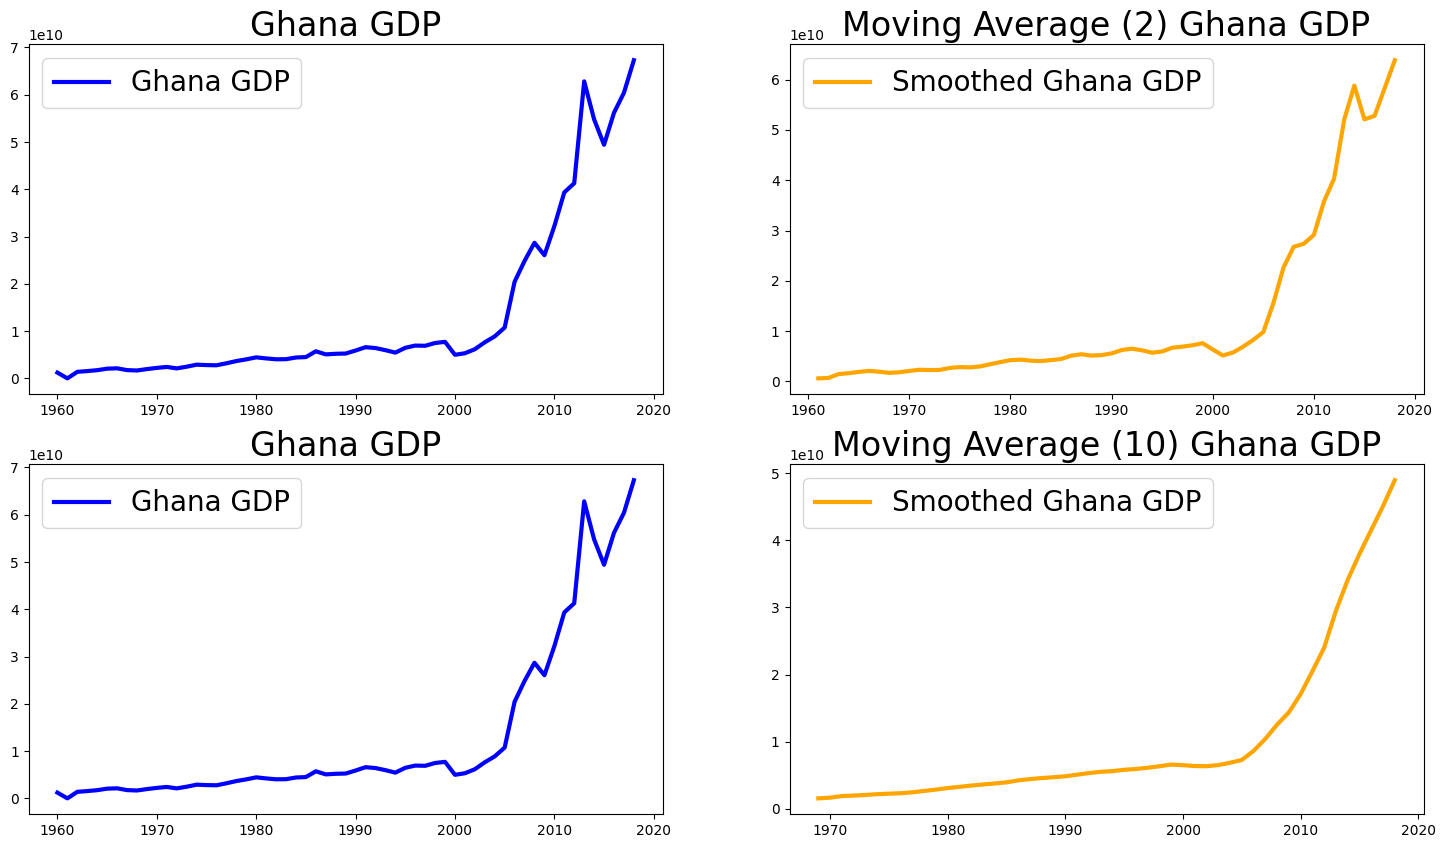

In [86]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в 2 лет (Window = 2)
ax[0, 0].plot(train_df["GDP (current US$)"], color="blue", label="Ghana GDP")
ax[0, 0].set_title("Ghana GDP", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df["GDP (current US$)"].rolling(window=2).mean(),
    color="orange",
    label="Smoothed Ghana GDP",
)

ax[0, 1].set_title("Moving Average (2) Ghana GDP", size=24)
ax[0, 1].legend()


# Окно в 10 лет (Window = 10)
ax[1, 0].plot(train_df["GDP (current US$)"], color="blue", label="Ghana GDP")
ax[1, 0].set_title("Ghana GDP", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df["GDP (current US$)"].rolling(window=10).mean(),
    color="orange",
    label="Smoothed Ghana GDP",
)

ax[1, 1].set_title("Moving Average (10) Ghana GDP", size=24)
ax[1, 1].legend()

plt.show()

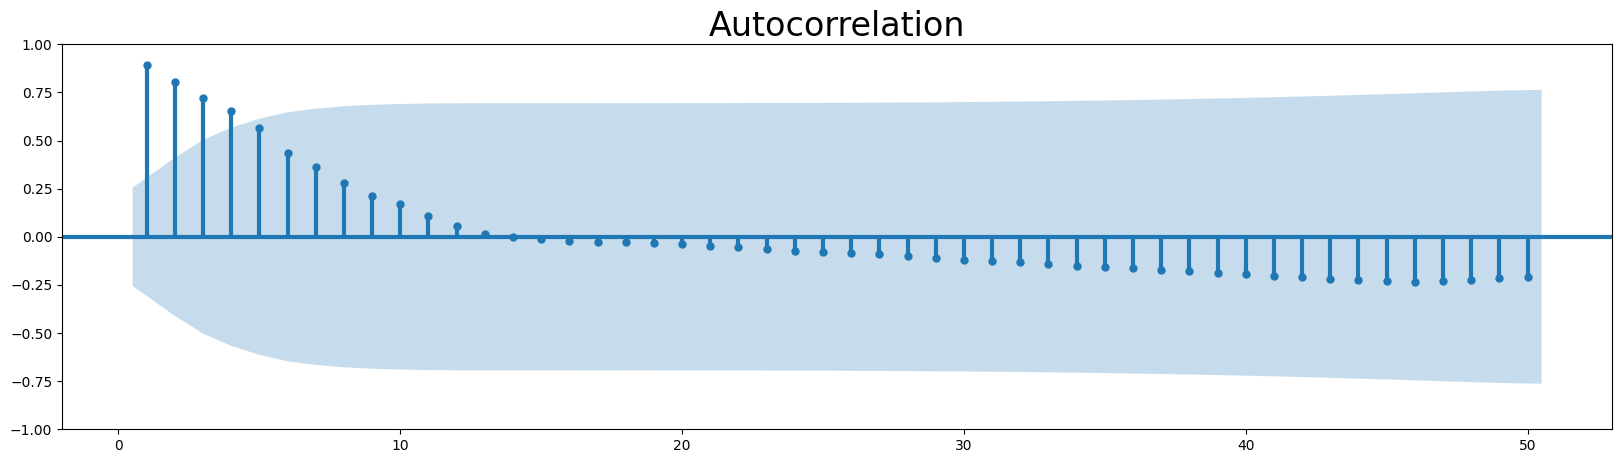

In [87]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df["GDP (current US$)"], lags=50, zero=False)
plt.show()

> Вывод: 
> - Наблюдается хорошая корреляция с Лагом до 4


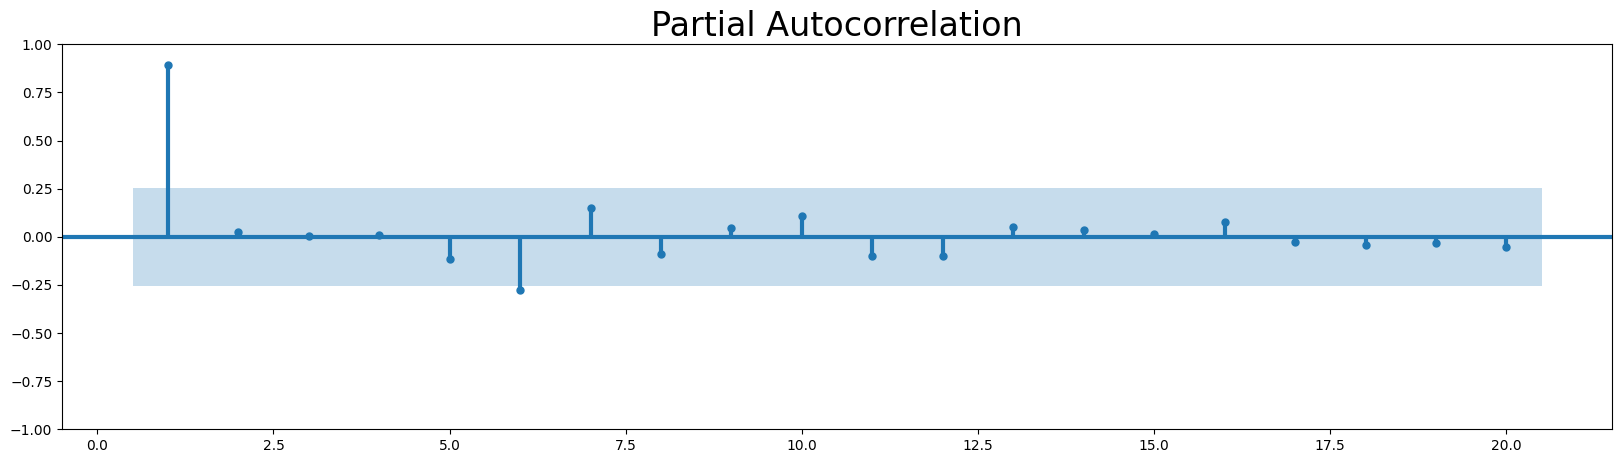

In [88]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df["GDP (current US$)"], lags=20, method="ywm", zero=False)
plt.show()

> Вывод: 
> - GDP (current US$) с лагом >1 не приносят никакой новой информации. В такой ситуации выбираем параметр p =1
> - Судя по графику Лаг "самый отличный от нуля" первый, выбираем p=1.


### 3. С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.


*Примечание. Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA.*

Параметры p и q выберите по коррелограммам ACF и PACF.

*Примечание. Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.*

Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.

Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).

In [89]:
adfuller(train_df["GDP (current US$)"])

(np.float64(0.6529066974885349),
 np.float64(0.9888496277665572),
 10,
 48,
 {'1%': np.float64(-3.5745892596209488),
  '5%': np.float64(-2.9239543084490744),
  '10%': np.float64(-2.6000391840277777)},
 np.float64(2194.301372914139))

In [90]:
test1 = adfuller(train_df["GDP (current US$)"])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.6529066974885349
p-value:  0.9888496277665572
Critical values:  {'1%': np.float64(-3.5745892596209488), '5%': np.float64(-2.9239543084490744), '10%': np.float64(-2.6000391840277777)}
ряд нестационарен


> Вывод: Наша статистика больше всех критических значений разных уровней значимости, следовательно мы не можем опровергнуть нулевую теорию. Следовательно наш ряд не является стационарным.

In [91]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=25)
    sgt.plot_pacf(series, ax=axes[1], lags=25, method="ywm")
    plt.show()

## Дифференцирование ряда
$y\_new_t = y_t - y_{t-1}$

where, 
- $y\_new_t$: Дифференцированное значение ряда $t$
- $y_t$: Фактическое значение ряда $t$
- $y_{t-1}$: Фактическое значение ряда $t-1$

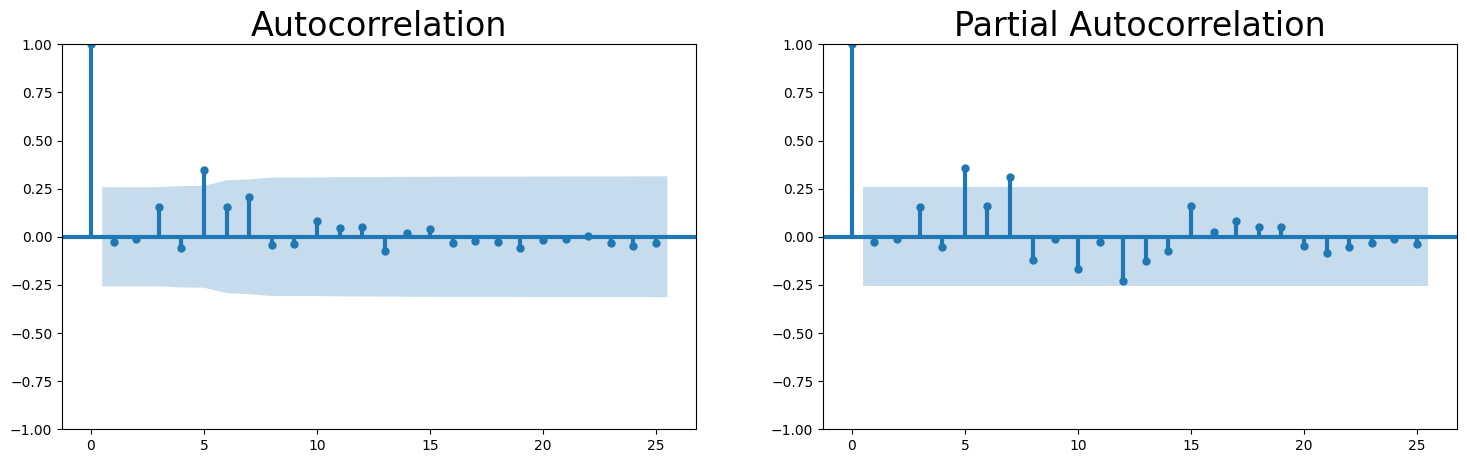

(np.float64(-1.6702483038320777),
 np.float64(0.446502932971389),
 7,
 50,
 {'1%': np.float64(-3.568485864),
  '5%': np.float64(-2.92135992),
  '10%': np.float64(-2.5986616)},
 np.float64(2147.2038799920597))

In [92]:
plot_acf_pacf(train_df["GDP (current US$)"].diff().dropna())
adfuller(train_df["GDP (current US$)"].diff().dropna())

In [93]:
# Тест Дики-Фуллера для дифференцированных данных (первые разности)
diff_test = adfuller(train_df["GDP (current US$)"].diff().dropna())
print("=== Тест Дики-Фуллера для дифференцированных данных ===")
print("adf: ", diff_test[0])
print("p-value: ", diff_test[1])
print("Critical values: ", diff_test[4])
if diff_test[0] > diff_test[4]["5%"]:
    print("Дифференцированный ряд НЕстационарен")
else:
    print("Дифференцированный ряд стационарен")

=== Тест Дики-Фуллера для дифференцированных данных ===
adf:  -1.6702483038320777
p-value:  0.446502932971389
Critical values:  {'1%': np.float64(-3.568485864), '5%': np.float64(-2.92135992), '10%': np.float64(-2.5986616)}
Дифференцированный ряд НЕстационарен


> Вывод:
> - Первые разности являются стационарными
> - Продолжаем дифференцирование

=== Тест Дики-Фуллера для вторых разностей ===
adf:  -2.6408690561284898
p-value:  0.08484116917837664
Critical values:  {'1%': np.float64(-3.5714715250448363), '5%': np.float64(-2.922629480573571), '10%': np.float64(-2.5993358475635153)}
Вторые разности НЕстационарны


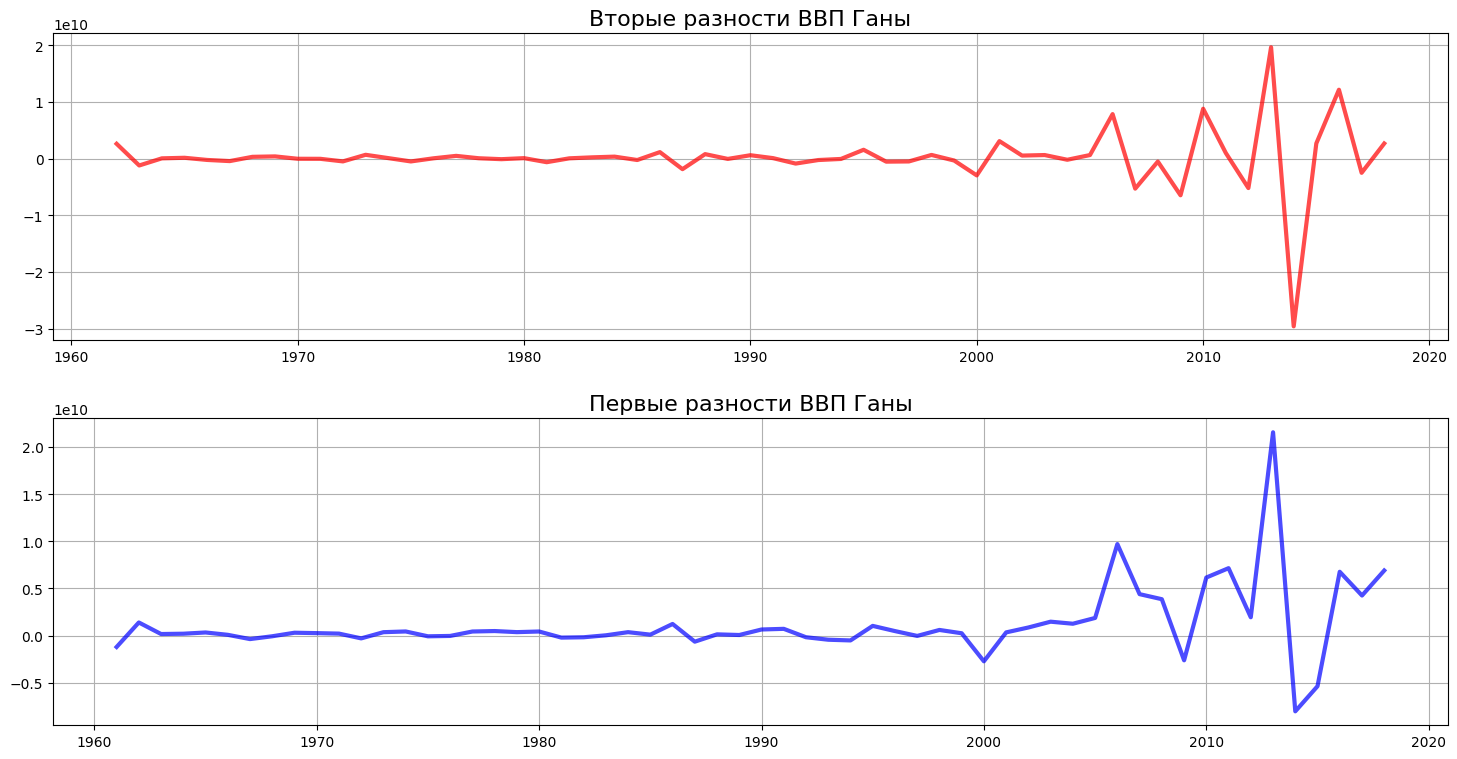

In [94]:
# Проверим вторые разности (d=2)
second_diff = train_df["GDP (current US$)"].diff().diff().dropna()
second_diff_test = adfuller(second_diff)

print("=== Тест Дики-Фуллера для вторых разностей ===")
print("adf: ", second_diff_test[0])
print("p-value: ", second_diff_test[1])
print("Critical values: ", second_diff_test[4])

if second_diff_test[0] > second_diff_test[4]["5%"]:
    print("Вторые разности НЕстационарны")
else:
    print("Вторые разности стационарны")
    
# Визуализируем вторые разности
plt.rcParams["figure.figsize"] = 15, 8
fig, axes = plt.subplots(2, 1)

# График вторых разностей
axes[0].plot(second_diff, color='red', alpha=0.7)
axes[0].set_title('Вторые разности ВВП Ганы' , size=16)
axes[0].grid(True)

# График первых разностей для сравнения  
axes[1].plot(train_df["GDP (current US$)"].diff().dropna(), color='blue', alpha=0.7)
axes[1].set_title('Первые разности ВВП Ганы', size=16)
axes[1].grid(True)

plt.tight_layout()
plt.show()

> Вывод:
> - Вторые разности d=2 показывают значительное улучшение
> - Результат: На 5% уровне значимости НЕстационарны, но на 10% уровне стационарны
> - Визуально вторые разности ведут себя более стационарно до 2000-х годов, но показывают повышенную волатильность в последние годы
> - Будем использовать d=2 (вторые разности). Сравним их с d=3 и сравним AIC 

## ARIMA, SARIMA

Начнем построение модели **ARIMA** со следующими параметрами:

- p = 1 
- d = 2 
- q = 1 


In [95]:
arima_model = ARIMA(train_df["GDP (current US$)"].dropna(), order=(1, 2, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1339.208
Date:                Sun, 08 Feb 2026   AIC                           2684.416
Time:                        22:08:18   BIC                           2690.545
Sample:                    01-01-1960   HQIC                          2686.798
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1775      0.082     -2.159      0.031      -0.339      -0.016
ma.L1         -0.8688      0.046    -19.069      0.000      -0.958      -0.780
sigma2       1.96e+19   2.13e-22    9.2e+40      0.000    1.96e+19    1.96e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               276.42
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             325.65   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.49e+56. Standard errors may be unstable.
"""

Сравним с моделью **ARIMA** со следующими параметрами:

- p = 1 
- d = 3 (дифференцирование и сравним AIC) 
- q = 1 

In [96]:
arima_model_2 = ARIMA(train_df["GDP (current US$)"].dropna(), order=(1, 3, 1))
arima_model_fit_2 = arima_model.fit()
arima_model_fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1339.208
Date:                Sun, 08 Feb 2026   AIC                           2684.416
Time:                        22:08:18   BIC                           2690.545
Sample:                    01-01-1960   HQIC                          2686.798
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1775      0.082     -2.159      0.031      -0.339      -0.016
ma.L1         -0.8688      0.046    -19.069      0.000      -0.958      -0.780
sigma2       1.96e+19   2.13e-22    9.2e+40      0.000    1.96e+19    1.96e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               276.42
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             325.65   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.49e+56. Standard errors may be unstable.
"""

> Вывод:
> - AIC для d=2 составляет 2684
> - AIC для d=3 составляет 2670 (немного лучше)
> - Разность не значительна, оставим d=2 

In [97]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["GDP (current US$)"] = data["GDP (current US$)"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

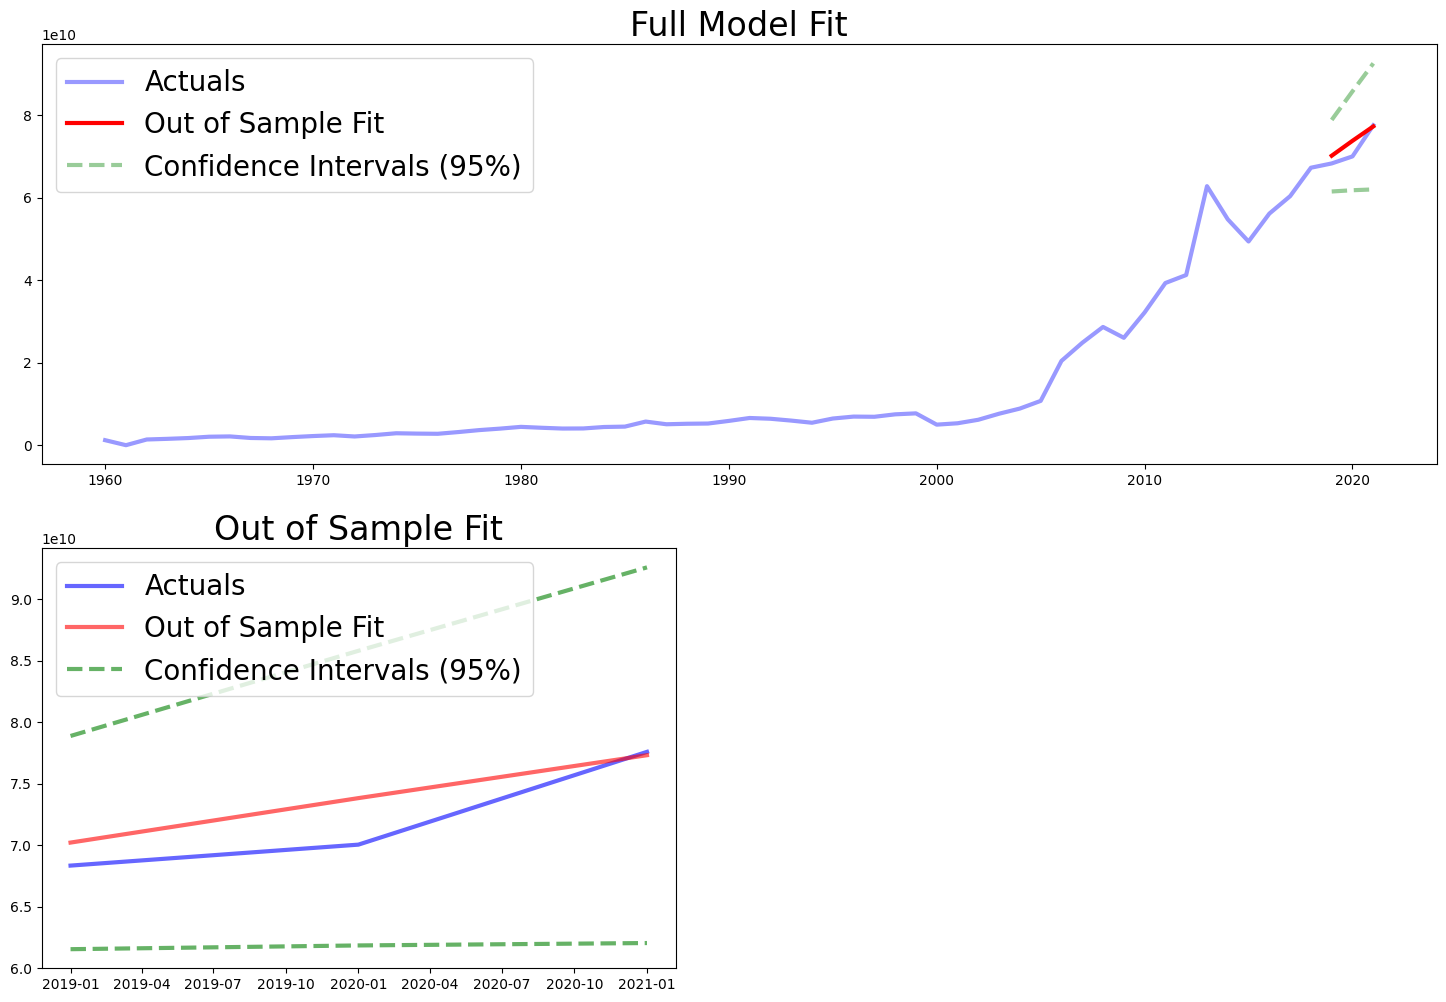

In [98]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

> Вывод:
> - Предсказания уловили тренд и очень близки к реальным значения ВВП за последние 3 года
> - Далее проверю по сетке и подберу лучшие значения по библиотеке "pmdarima"

### 4. Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).
### 5. Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.
### 6. Сделайте выводы по полученным результатам.

Пробежимся по сетке и найдем лучшие значения p, d, q

In [99]:
# Автоматический подбор оптимальной ARIMA модели 
# Используем результаты наших тестов: d=2 для стационарности
smodel = pm.auto_arima(
    train_df["GDP (current US$)"],  # Указываем конкретную колонку
    start_p=0,
    d=2,  # Используем d=2 как выявили в анализе стационарности
    start_q=0,
    max_p=5,  # Расширяем диапазон поиска
    max_q=5,
    seasonal=False,  # Убираем сезоность, так как её нет в годовых данных
    test="adf", 
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
    trace=True,
)

print("=== Результаты автоматического подбора ARIMA ===")
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.886, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.594, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.662, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.339, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.054, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.896, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.06 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.926, Time=0.03 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.782, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2693.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Sun, 08 Feb 2026   AIC                           2680.765
Time:                        22:08:21   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.62e+54. Standard errors may be unstable.
"""

> Используем "Best model:  ARIMA(1,2,3)"

In [100]:
arima_model_best = ARIMA(train_df["GDP (current US$)"].dropna(), order=(1, 2, 3))
arima_model_best_fit = arima_model_best.fit()
arima_model_best_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Sun, 08 Feb 2026   AIC                           2680.765
Time:                        22:08:21   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.62e+54. Standard errors may be unstable.
"""

In [101]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_best_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["GDP (current US$)"] = data["GDP (current US$)"]

forecast = arima_model_best_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

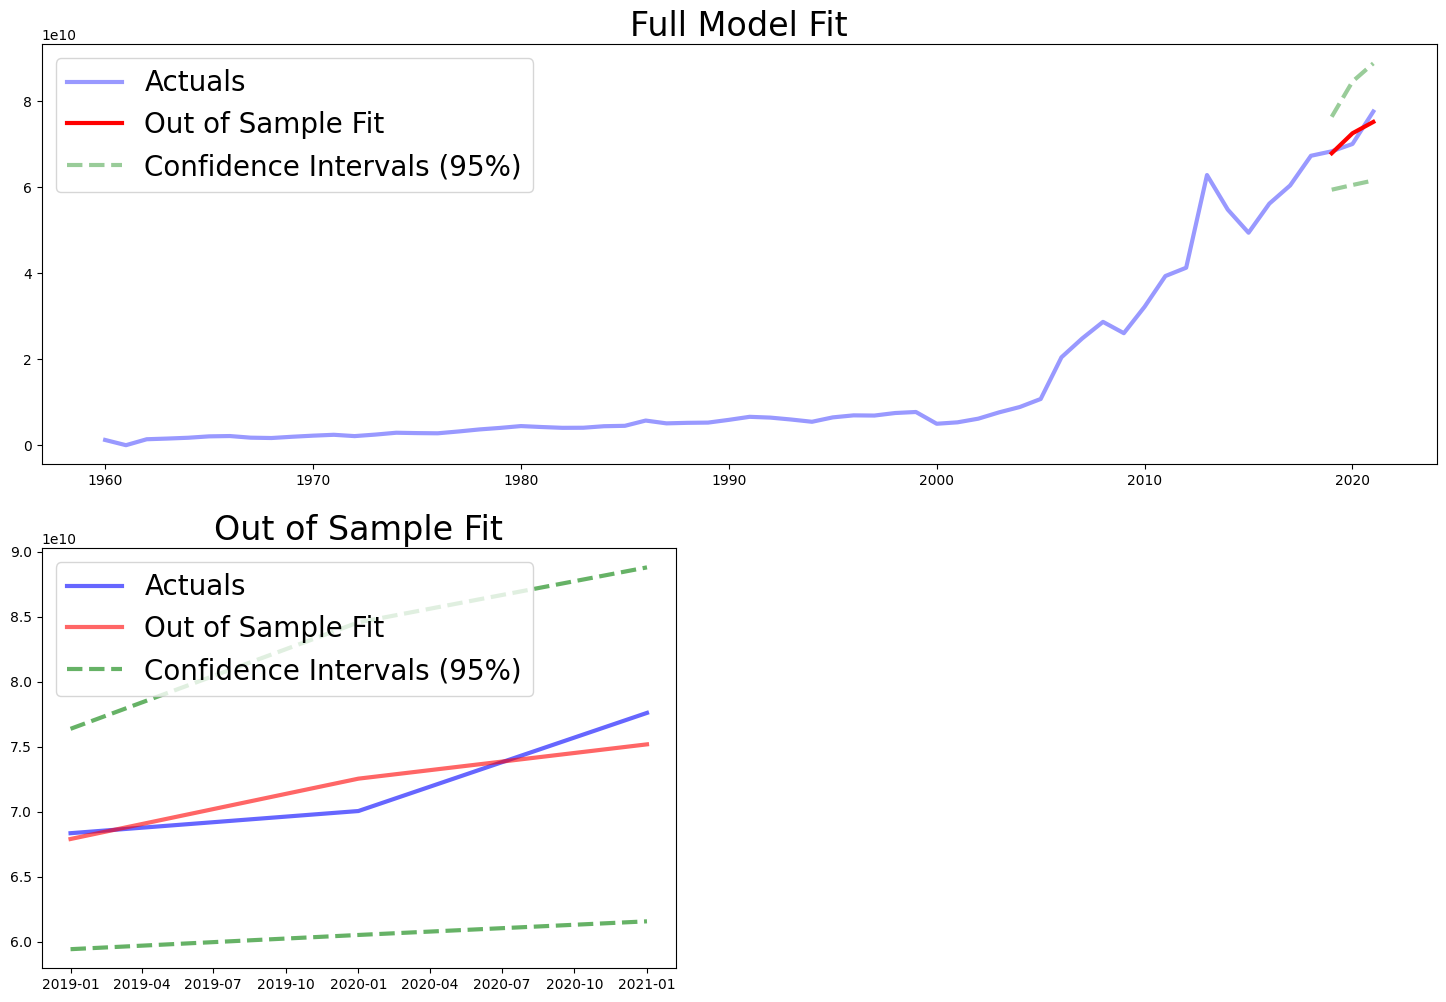

In [102]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

> Вывод:
> - Предсказания ВВП за последние 3 года улучшились по сравнению с первой моделью
> - Предсказания уловили тренд и очень близки к реальным значения ВВП